# Baseline model
The baseline model is based on the assumption that the particulate matter (PM) concentration doesn't change to much from day to day. Hence, the simplest model is that PM of an hour equals PM of yesterday's same hour. This model yields equal values for equal hours of all days to come and will be called PM_simple in the following.

As wether predictions are quite trustworthy for the next three days to come, we'll also try a model that takes the weighted PM of the previous three days into account:

$ PM^{\mathrm{day}} = \frac{w_1 PM^{\mathrm{day-1}} + w_2 PM^{\mathrm{day-2}} + w_3 PM^{\mathrm{day-3}}}{w_1 + w_2 + w_3}
$
$\mathrm{with\ } w_i = \mathrm{weight\ of\ day}{-i}
$
This model yields different results for the days to come. Depending on how far the prediction reaches into the future it will be called PM_day1, PM_day2, ... in the following.

At first we'll check whether PM_simple or PM_day1 yields the best results in terms of root mean squared error (RMSE). For this we use the cleaned train data set. Then we'll predict with the better baseline model the PM values of the test data.

## Import libraries

In [2]:
# fundamentals
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

#  printing of number without scientific notation
np.set_printoptions(precision=3,suppress=True)

# metric
from sklearn.metrics import mean_squared_error as MSE

## Predict PM for cleaned train data


### Load data

In [3]:
# load cleaned training data
df_base = pd.read_csv("../data/cleaned_sensors_dwd_train.csv", index_col=0)[['location_id', 'timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# convert timestamp to datetime
df_base.timestamp = pd.to_datetime(df_base.timestamp)

# save assignment of location_id to coordinates for setting location_id of the test data later on
location_id_assignment = pd.DataFrame(
    data={
        'location_id': df_base['location_id'].unique()
    }
)
for l in ['lat', 'lon']:
    location_id_assignment[l] = location_id_assignment.apply(lambda x: df_base.loc[df_base['location_id']==x['location_id'], l].iloc[0], axis=1)

display(df_base)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376
...,...,...,...,...,...,...,...,...,...
2807035,94,2021-12-31 19:00:00,Frankfurt,50.145034,8.794068,10.916667,2.073651,7.566667,0.995483
2807036,94,2021-12-31 20:00:00,Frankfurt,50.145034,8.794068,10.176667,2.014474,6.306667,0.447109
2807037,94,2021-12-31 21:00:00,Frankfurt,50.145034,8.794068,10.386667,1.574061,6.823333,0.920471
2807038,94,2021-12-31 22:00:00,Frankfurt,50.145034,8.794068,9.858000,2.431033,7.612000,1.784312


In [6]:
df_base.sort_values('location_id').groupby('location_id').lat.count()

location_id
2      17544
8      17544
10     17544
11     17544
12     17544
       ...  
167    17544
169    17544
170    17544
180    17544
182    17544
Name: lat, Length: 66, dtype: int64

> the data set comprises 66 locations

### Simple model: PM_simple

In [9]:
# give predicted values for PM2.5 and PM10 as PM values of previous day
df_base['PM2p5_simple'] = df_base.groupby(['location_id'])['PM2p5'].shift(24)
df_base['PM10_simple'] = df_base.groupby(['location_id'])['PM10'].shift(24)

### 3day-model: PM_day1, PM_day2, PM_day3

In [10]:
# set weights
w1, w2, w3 = 3, 2, 1

# calculate predicted values for PM10 as mean of previous three days with weights w1-w3
df_base['PM10_day1'] = (df_base.groupby(['location_id'])['PM10'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM10_day2'] = (df_base.groupby(['location_id'])['PM10_day1'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM10_day3'] = (df_base.groupby(['location_id'])['PM10_day2'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10_day1'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 

# calculate predicted values for PM10 as mean of previous three days with weights w1-w3
df_base['PM2p5_day1'] = (df_base.groupby(['location_id'])['PM2p5'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM2p5_day2'] = (df_base.groupby(['location_id'])['PM2p5_day1'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM2p5_day3'] = (df_base.groupby(['location_id'])['PM2p5_day2'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5_day1'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 

# show DataFrame for location 125 per day at 1:00 am
df_base.query("location_id==125 and timestamp > '2020-01-03'")[::24].head()

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,PM10_day1,PM10_day2,PM10_day3,PM2p5_day1,PM2p5_day2,PM2p5_day3,PM2p5_simple,PM10_simple
1052689,125,2020-01-03 01:00:00,Bremen,53.014,8.886,22.932800,2.191939,13.984000,1.133641,NaN,NaN,NaN,NaN,NaN,NaN,37.565833,175.085000
1052713,125,2020-01-04 01:00:00,Bremen,53.014,8.886,35.376957,6.087851,5.366957,0.721604,188.209247,NaN,NaN,84.177000,NaN,NaN,13.984000,22.932800
1052737,125,2020-01-05 01:00:00,Bremen,53.014,8.886,23.547826,5.080958,4.773478,0.720717,54.513578,130.929724,NaN,13.605784,53.010806,NaN,5.366957,35.376957
1052761,125,2020-01-06 01:00:00,Bremen,53.014,8.886,34.710417,2.424972,19.190833,1.196291,27.388365,42.871241,132.023411,6.506391,10.922544,56.895069,4.773478,23.547826
1052785,125,2020-01-07 01:00:00,Bremen,53.014,8.886,30.317143,5.226279,17.053810,2.559876,31.100643,27.439617,45.502973,12.081069,5.738848,10.891026,19.190833,34.710417


### Compare simple and 3day-model

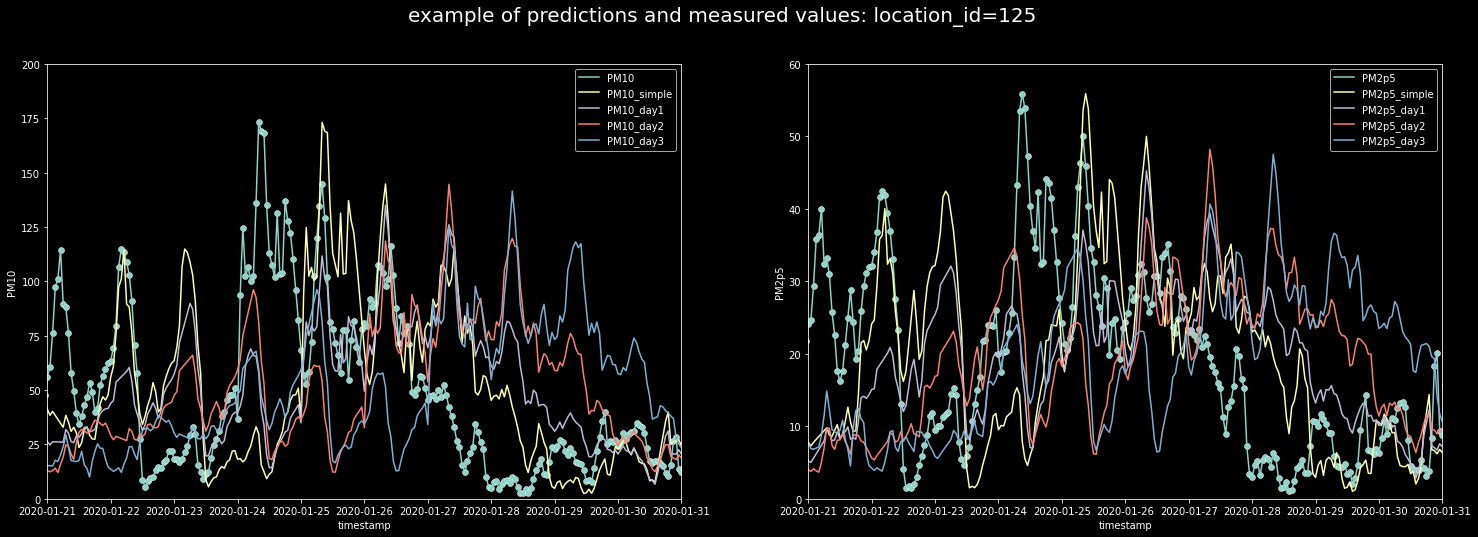

In [19]:
# plot example: PM prediction as function of time
location = 125 # choose location_id

plt.figure(figsize=(25, 8))
plt.suptitle(f"example of predictions and measured values: location_id={location}", fontsize=20) # title of plot

# PM10
plt.subplot(1,2,1)
columns = ['PM10', 'PM10_simple', 'PM10_day1', 'PM10_day2', 'PM10_day3']
for col in columns:
    sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y=col)
sns.scatterplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10')
plt.legend(columns)
plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0,200)

# PM2.5
plt.subplot(1,2,2)
columns = ['PM2p5', 'PM2p5_simple', 'PM2p5_day1', 'PM2p5_day2', 'PM2p5_day3']
for col in columns:
    sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y=col)
sns.scatterplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5')
plt.legend(columns)
plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0,60);

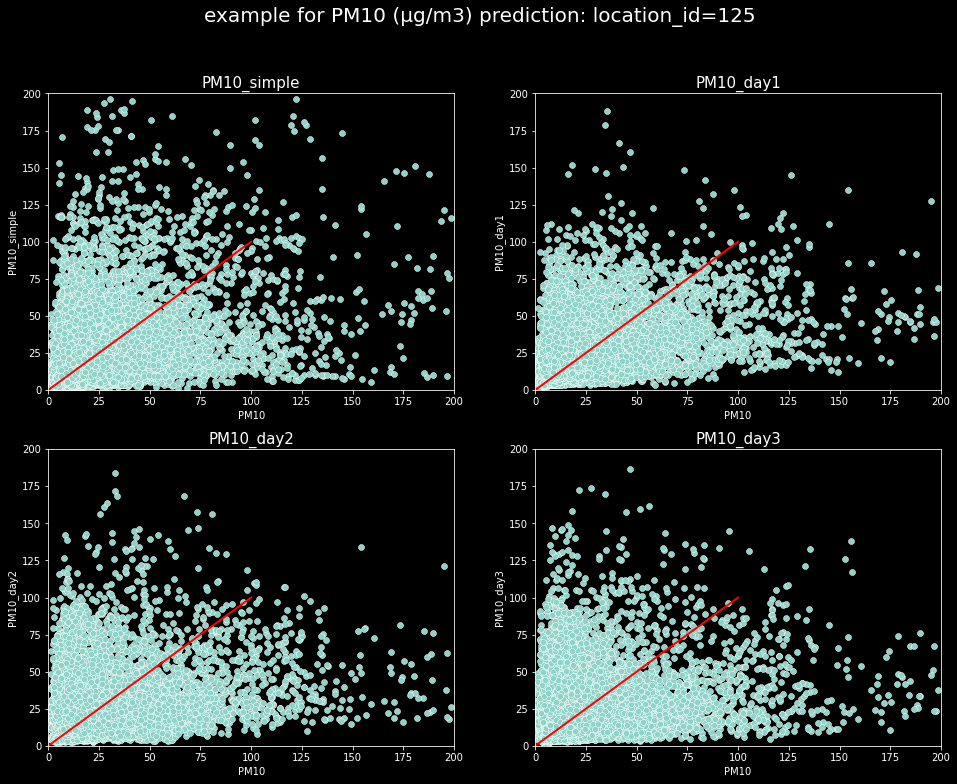

In [29]:
# plot example: PM10 prediction vs. true values
location = 125
plt.figure(figsize=(16, 12))
plt.suptitle(f"example for PM10 (µg/m3) prediction: location_id={location}", fontsize=20) # title of plot

models = ['PM10_simple', 'PM10_day1', 'PM10_day2', 'PM10_day3']

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.title(models[i-1], fontsize=15)
    sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y=models[i-1])
    plt.plot([0, 100], [0, 100], linewidth=2, color='red')
    plt.xlim(0,200)
    plt.ylim(0,200);

### Root mean squared error (RMSE)
The RMSE will be calculated for both models over all data points, per location and per city, respectively.

In [38]:
# calculate root mean squared error (RMSE) per location, for all data points and per city
locations_max = df_base.location_id.max() # maximum location_id
df_RMSE = df_base.groupby(['location_id', 'city', 'lat', 'lon']).PM10.count().reset_index().drop('PM10', axis=1) # create DataFrame for results

def calc_rmse(PM, base_model, df):
    """calculates RMSE for given PM type and baseline model and adds it to dataframe df_RMSE
    Args:
        PM (str): particulate matter type (PM10 or PM2.5)
        base_model (str): name of baseline model
        df (DataFrame): DataFrame with measured and predicted values
    Return: 
        rmse_all (float): RMSE for all locations
        rmse_Bremen (float) RMSE for Bremen
        rmse_Frankfurt (float) RMSE for Frankfurt
    """
    # RMSE for all locations
    df_sensor = df.dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
    rmse_all = round(MSE(df_sensor[PM], df_sensor[f"{PM}_{base_model}"], squared=False), 2)
    print(f"RMSE of {PM} for all data points:", round(rmse_all,2), "µg/m3")

    # RMSE for Bremen
    df_Bremen = df_sensor[df_sensor['city'] == 'Bremen']
    rmse_Bremen = round(MSE(df_Bremen[PM], df_Bremen[f"{PM}_{base_model}"], squared=False),2)

    # RMSE for Frankfurt
    df_Frankfurt = df_sensor[df_sensor['city'] == 'Frankfurt']
    rmse_Frankfurt = round(MSE(df_Frankfurt[PM], df_Frankfurt[f"{PM}_{base_model}"], squared=False),2)

    # RMSE per location
    for i in range(1,locations_max+1):
        df_sensor = df[df['location_id']==i].dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
        if df_sensor.shape[0] != 0:     # check that rows for this location remain
            rmse = np.sqrt(MSE(df_sensor[f"{PM}"], df_sensor[f"{PM}_{base_model}"]))
            df_RMSE.loc[i-1,f"{PM}_{base_model}"] = rmse
    return rmse_all, rmse_Bremen, rmse_Frankfurt

RMSE of PM10 for all data points: 14.94 µg/m3
RMSE of PM2p5 for all data points: 7.75 µg/m3
RMSE of PM10 for all data points: 14.12 µg/m3
RMSE of PM2p5 for all data points: 7.29 µg/m3
RMSE of PM10 for all data points: 12.71 µg/m3
RMSE of PM2p5 for all data points: 6.48 µg/m3
RMSE of PM10 for all data points: 14.12 µg/m3
RMSE of PM2p5 for all data points: 7.11 µg/m3


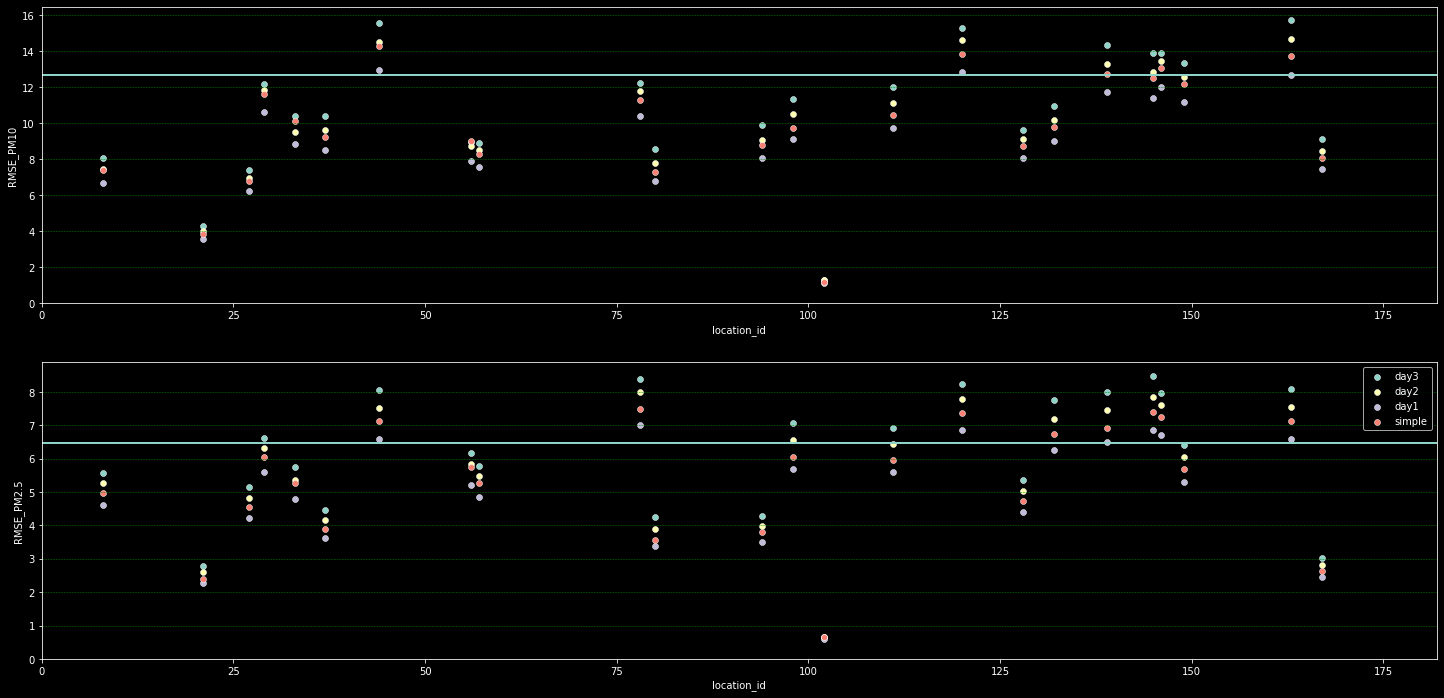

In [39]:
# save RMSE for both models for each location, for all data points, Bremen and Frankfurt, respectively and print RMSE for both models for all data points
base_line_models = ['day3', 'day2', 'day1', 'simple']
plt.figure(figsize=(25, 12))

rmse_all = dict()
rmse_Bremen = dict()
rmse_Frankfurt = dict()
for model in base_line_models:
    rmse_all[f"{model}_PM10"], rmse_Bremen[f"{model}_PM10"], rmse_Frankfurt[f"{model}_PM10"] = calc_rmse('PM10', model, df_base)
    rmse_all[f"{model}_PM2p5"], rmse_Bremen[f"{model}_PM2p5"], rmse_Frankfurt[f"{model}_PM2p5"] = calc_rmse('PM2p5', model, df_base)
    #df_RMSE.plot(kind='scatter', x='location_id', y=f"PM10_{model}")
    plt.subplot(2,1,1)
    sns.scatterplot(data=df_RMSE, x='location_id', y=f"PM10_{model}")
    plt.subplot(2,1,2)
    sns.scatterplot(data=df_RMSE, x='location_id', y=f"PM2p5_{model}")


# plot RMSE_PM10 per location
plt.subplot(2,1,1)
plt.plot([0, locations_max], [rmse_all['day1_PM10'], rmse_all['day1_PM10']], linewidth=2)
plt.xlim(0,locations_max)
plt.ylabel('RMSE_PM10')
plt.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0)

# plot RMSE_PM2.5 per location# plot PM2.5
plt.subplot(2,1,2)
plt.plot([0, locations_max], [rmse_all['day1_PM2p5'], rmse_all['day1_PM2p5']], linewidth=2)
plt.legend(base_line_models)
plt.xlim(0,locations_max)
plt.ylabel('RMSE_PM2.5')
plt.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0);

In [40]:
# show RMSE for both models, the predicted days and all locations per city
print('Frankfurt')
display(rmse_Frankfurt)
print('Bremen')
display(rmse_Bremen)

Frankfurt


{'day3_PM10': 11.78,
 'day3_PM2p5': 6.42,
 'day2_PM10': 11.06,
 'day2_PM2p5': 6.01,
 'day1_PM10': 9.87,
 'day1_PM2p5': 5.29,
 'simple_PM10': 10.85,
 'simple_PM2p5': 5.73}

Bremen


{'day3_PM10': 20.09,
 'day3_PM2p5': 10.02,
 'day2_PM10': 19.07,
 'day2_PM2p5': 9.46,
 'day1_PM10': 17.26,
 'day1_PM2p5': 8.48,
 'simple_PM10': 19.32,
 'simple_PM2p5': 9.41}

> The model that takes into account the weighted previous three days performs better than the simple model (compare simple and day1).
> The predictions worsen the farer they reach into the future (see day1, day2, day3).

Let's look at the RMSE for each measurement.

In [45]:
# calculate RMSE for each measurement and both models
df_PM10_simple_rmse = df_base[['PM10', 'PM10_simple']].dropna(axis=0)       
df_PM10_simple_rmse['RMSE_PM10_simple'] = np.sqrt((df_PM10_simple_rmse['PM10'] - df_PM10_simple_rmse['PM10_simple'])**2)

df_PM10_day1_rmse = df_base[['PM10', 'PM10_day1']].dropna(axis=0)       
df_PM10_day1_rmse['RMSE_PM10_day1'] = np.sqrt((df_PM10_day1_rmse['PM10'] - df_PM10_day1_rmse['PM10_day1'])**2)

df_PM10_day2_rmse = df_base[['PM10', 'PM10_day2']].dropna(axis=0)       
df_PM10_day2_rmse['RMSE_PM10_day2'] = np.sqrt((df_PM10_day2_rmse['PM10'] - df_PM10_day2_rmse['PM10_day2'])**2)

df_PM10_day3_rmse = df_base[['PM10', 'PM10_day3']].dropna(axis=0)       
df_PM10_day3_rmse['RMSE_PM10_day3'] = np.sqrt((df_PM10_day3_rmse['PM10'] - df_PM10_day3_rmse['PM10_day3'])**2)

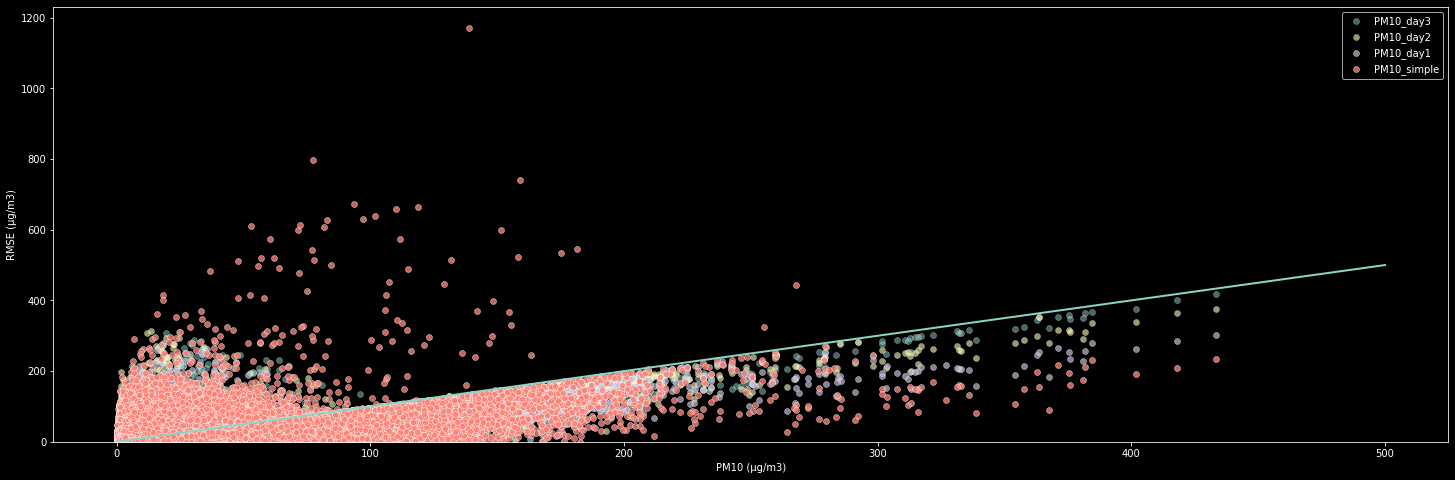

In [47]:
# plot RMSE vs. measurement for PM10
plt.figure(figsize=(25, 8))
columns = ['PM10_day3', 'PM10_day2', 'PM10_day1', 'PM10_simple']
sns.scatterplot(data=df_PM10_day3_rmse, x='PM10', y='RMSE_PM10_day3', alpha=0.5)
sns.scatterplot(data=df_PM10_day2_rmse, x='PM10', y='RMSE_PM10_day2', alpha=0.6)
sns.scatterplot(data=df_PM10_day1_rmse, x='PM10', y='RMSE_PM10_day1', alpha=0.7)
sns.scatterplot(data=df_PM10_simple_rmse, x='PM10', y='RMSE_PM10_simple', alpha=0.8)
#sns.scatterplot(data=df_PM10_1day_simple, x='PM10', y='RMSE_PM10_1day_simple', alpha=0.9)
plt.plot([0, 500], [0, 500], linewidth=2)
plt.legend(columns)
#plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0);
plt.ylabel('RMSE (µg/m3)')
plt.xlabel('PM10 (µg/m3)');

> The simple model works better for high PM values, but is sometimes really bad for low PM10 values.

> We'll use the model taking into account the weighted last three days as baseline model.

## Predicting the test data with the baseline model
### Load train and test data and merge it to one DataFrame

In [50]:
# load cleaned test data
df_test = pd.read_csv("../data/cleaned_sensors_dwd_test.csv", index_col=0)[['timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# load uncleaned test data
#df_test = pd.read_csv("../data/processed_sensor_dwd_test.csv", index_col=0)[['timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# convert timestamp to datetime
df_test.timestamp = pd.to_datetime(df_test.timestamp)

# assign location IDs according to coordinates
df_test['location_id'] = df_test.apply(
    lambda x: location_id_assignment.\
        loc[(location_id_assignment['lat'] == x['lat']) & (location_id_assignment['lon'] == x['lon']), 'location_id'].\
            iloc[0], 
            axis=1
)

# mark test data
df_test['test'] = True

display(df_test.sample(1))
df_test.shape

,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,location_id,test
65416,2022-01-12 16:00:00,Frankfurt,50.15,8.568,11.81625,3.625391,6.830833,1.855825,97,True


(93456, 10)

In [51]:
# take last 3 days of training data
df_base_train3 = df_base.query("timestamp > '2021-12-28 23:00:00'")[['location_id', 'timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# mark train data
df_base_train3['test'] = False

display(df_base_train3.sample(1))
df_base_train3.shape

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test
526315,62,2021-12-31 19:00:00,Frankfurt,50.124,8.688,7.295,1.497978,2.780417,0.274614,False


(4752, 10)

In [52]:
# merge train and test
df_base_test = pd.concat([df_base_train3, df_test])

# add columns for predicted PM values
df_base_test['PM10_pred'] = np.nan
df_base_test['PM2p5_pred'] = np.nan

# sort values and reset index
df_base_test.sort_values(['timestamp', 'location_id'], inplace=True)
df_base_test.reset_index(inplace=True)
df_base_test.drop('index', axis=1, inplace=True)

df_base_test

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test,PM10_pred,PM2p5_pred
0,2,2021-12-29 00:00:00,Frankfurt,50.042,8.436,1.455417,0.557900,0.751667,0.170642,False,NaN,NaN
1,8,2021-12-29 00:00:00,Frankfurt,50.056,8.678,0.719130,0.314872,0.590000,0.083775,False,NaN,NaN
2,10,2021-12-29 00:00:00,Frankfurt,50.058,8.688,1.250851,0.790264,0.533830,0.156560,False,NaN,NaN
3,11,2021-12-29 00:00:00,Frankfurt,50.070,8.436,2.611200,1.272898,0.670000,0.188282,False,NaN,NaN
4,12,2021-12-29 00:00:00,Frankfurt,50.074,8.436,1.398958,1.121870,0.723333,0.424366,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
98203,167,2022-02-28 23:00:00,Bremen,53.092,8.800,53.434348,2.033161,27.655217,1.043969,True,NaN,NaN
98204,169,2022-02-28 23:00:00,Bremen,53.094,8.778,28.411667,5.594093,16.520833,3.043353,True,NaN,NaN
98205,170,2022-02-28 23:00:00,Bremen,53.094,8.800,30.930000,2.525716,17.439167,1.082826,True,NaN,NaN
98206,180,2022-02-28 23:00:00,Bremen,53.132,8.708,5.765263,0.447950,5.185789,0.387317,True,NaN,NaN


### Prediction of test data

In [53]:
def predict_PM(PM, df):
    """predicts PM values for test data and saves them in columns of df

    Args:
        PM (str): PM type (PM10 or PM2p5)
        df (DataFrame): DataFrame with three days of train data and target test data
    """
    # set weights
    w1, w2, w3 = 3, 2, 1
    day1 = df['timestamp'].dt.date.min() + pd.Timedelta(days=3) # first test date
    last_day = df['timestamp'].dt.date.max() # last test date
    # days to be predicted
    days = (last_day - day1).days

    # calculate predicted values for PM as mean of previous three days with weights w1-w3
    # day 1
    end = df.query(f"'{day1} 23:00:00' == timestamp").index.max()
    df.loc[0:end,f'{PM}_pred_1'] = (df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(24) * w1 + df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(48) * w2 + df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(72) * w3) / (w1+w2+w3) 
    # day2
    end = df.query(f"'{day1 + pd.Timedelta(hours=24)} 23:00:00' == timestamp").index.max()
    df.loc[0:end,f'{PM}_pred_2'] = (df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_1'].shift(24) * w1 + df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(48) * w2 + df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(72) * w3) / (w1+w2+w3) 
    # day3
    end = df.query(f"'{day1 + pd.Timedelta(hours=48)} 23:00:00' == timestamp").index.max()
    df.loc[0:end,f'{PM}_pred_3'] = (df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_2'].shift(24) * w1 + df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_1'].shift(48) * w2 + df.loc[0:end].groupby(['location_id'])[f'{PM}'].shift(72) * w3) / (w1+w2+w3) 

    # day4 to end of prediction
    for day in range (4, days+1):
        end = df.query(f"'{day1 + pd.Timedelta(hours=(day-1)*24)} 23:00:00' == timestamp").index.max()
        df.loc[0:end,f'{PM}_pred_{day}'] = (df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_{day-1}'].shift(24) * w1 + df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_{day-2}'].shift(48) * w2 + df.loc[0:end].groupby(['location_id'])[f'{PM}_pred_{day-3}'].shift(72) * w3) / (w1+w2+w3) 

    # coalesce predicted values in one column
    for day in range(1, days+1):
        df[f'{PM}_pred'] = df[f'{PM}_pred'].combine_first(df[f'{PM}_pred_{day}'])
        df.drop(f'{PM}_pred_{day}', axis=1, inplace=True)
    pass


In [54]:
# PM prediction
predict_PM('PM10', df_base_test)
predict_PM('PM2p5', df_base_test)

In [86]:
# show results at given location and for fixed hour
df_base_test.query("location_id==125").loc[4050::24].head(10)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test,PM10_pred,PM2p5_pred
4072,125,2021-12-31 13:00:00,Bremen,53.014,8.886,8.885238,2.003234,4.012381,0.828589,False,NaN,NaN
5656,125,2022-01-01 13:00:00,Bremen,53.014,8.886,23.852174,3.866629,9.230000,1.568859,True,18.368970,7.976362
7240,125,2022-01-02 13:00:00,Bremen,53.014,8.886,8.598889,2.368506,3.605000,0.514921,True,14.094261,6.615944
8824,125,2022-01-03 13:00:00,Bremen,53.014,8.886,21.633571,4.181948,4.059286,0.828673,True,14.650993,6.635490
10408,125,2022-01-04 13:00:00,Bremen,53.014,8.886,13.080952,7.530958,5.208571,2.770609,True,15.085079,6.852453
11992,125,2022-01-05 13:00:00,Bremen,53.014,8.886,18.323684,5.250607,3.103158,0.753518,True,14.775247,6.740714
13576,125,2022-01-06 13:00:00,Bremen,53.014,8.886,20.878636,5.497976,4.914091,1.529864,True,14.857815,6.760423
15160,125,2022-01-07 13:00:00,Bremen,53.014,8.886,26.365789,2.620607,14.620526,0.740941,True,14.868170,6.769192
16744,125,2022-01-08 13:00:00,Bremen,53.014,8.886,28.879091,5.358704,14.271818,2.156577,True,14.849231,6.761522
18328,125,2022-01-09 13:00:00,Bremen,53.014,8.886,15.467500,3.675952,3.187083,0.809377,True,14.856975,6.763895


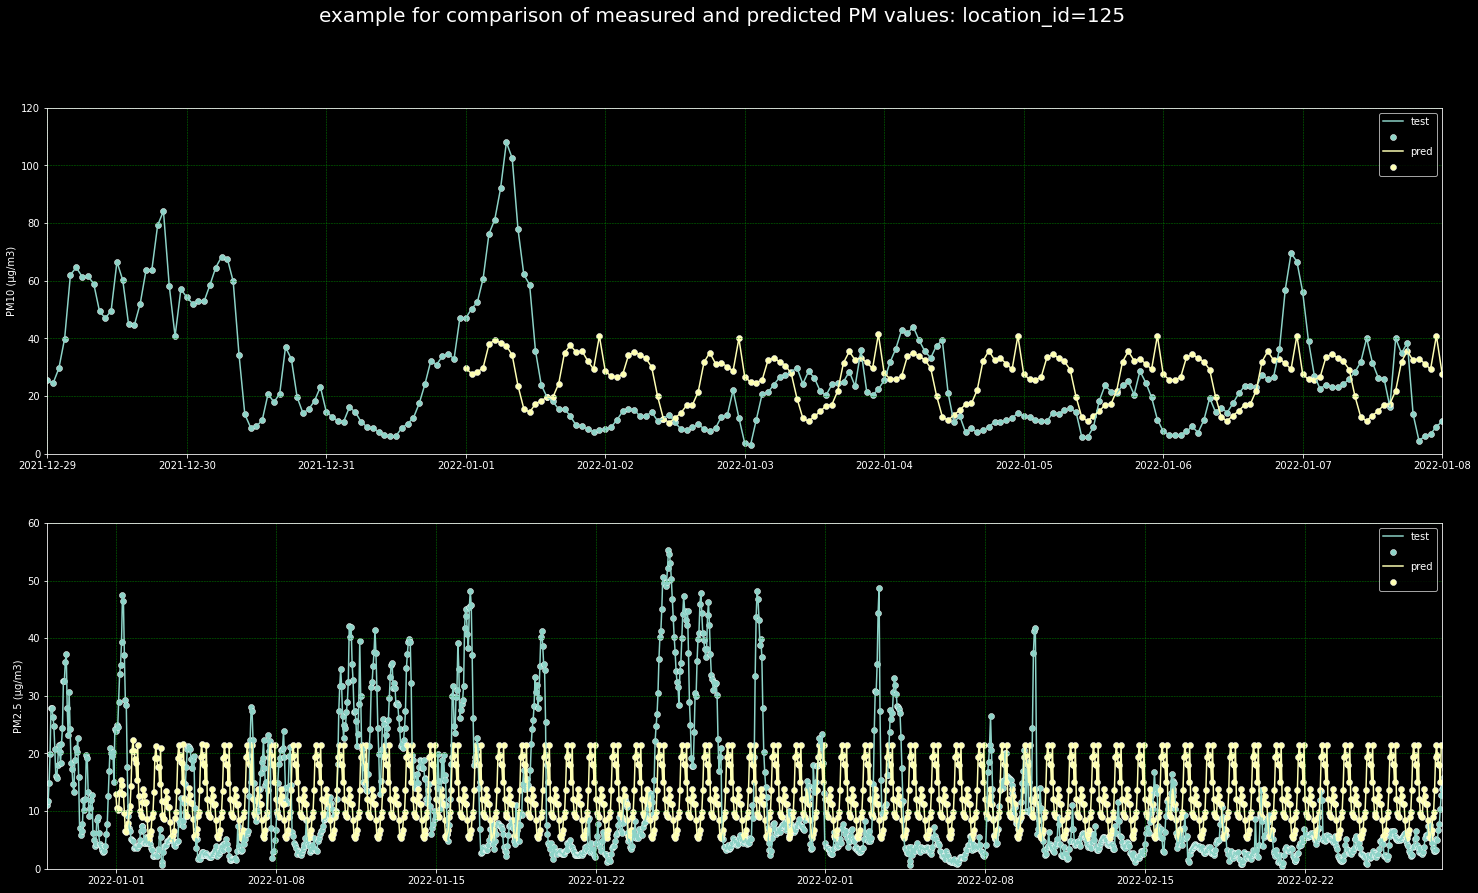

In [57]:
# plot example: prediction vs. true values
location = 125
plt.figure(figsize=(25, 14))
plt.suptitle(f"example for comparison of measured and predicted PM values: location_id={location}", fontsize=20) # title of plot

# PM10
plt.subplot(2,1,1)
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10')
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10_pred')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-01-08'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0,120)
plt.xlabel('')
plt.ylabel('PM10 (µg/m3)')
plt.legend(['test', '','pred', ''])

# PM2.5
plt.subplot(2,1,2)
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM2p5', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM2p5')
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM2p5_pred')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM2p5_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-02-28'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0,60)
plt.xlabel('')
plt.ylabel('PM2.5 (µg/m3)')
plt.legend(['test', '','pred', '']);


> prediction repeats itself every day

     location_id           timestamp
112          125 2021-12-29 01:00:00


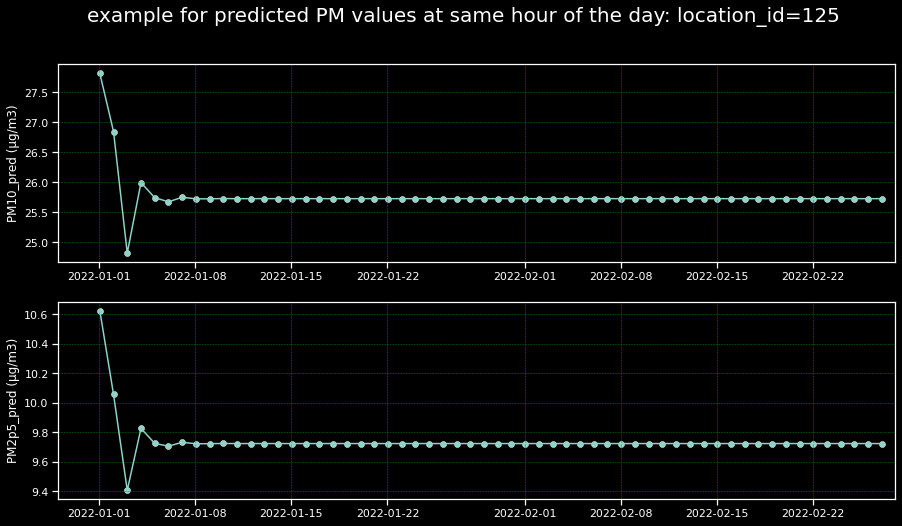

In [97]:
# plot example: prediction vs. true values for one hour of the day
location = 125
plt.figure(figsize=(15, 8))

plt.suptitle(f"example for predicted PM values at same hour of the day: location_id={location}", fontsize=20) # title of plot

# PM10
plt.subplot(2,1,1)
sns.lineplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM10_pred', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM10_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-02-28'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
##plt.ylim(4,5)
plt.xlabel('')
plt.ylabel('PM10_pred (µg/m3)')

# PM2.5
plt.subplot(2,1,2)
sns.lineplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM2p5_pred', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM2p5_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-02-28'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
#plt.ylim(1.5,2.5)
plt.xlabel('')
plt.ylabel('PM2p5_pred (µg/m3)');

print(df_base_test.query(f"location_id=={location}")[1:2][['location_id','timestamp']])

> predictions for a certain hour flatten quite fast

### Root mean squared error (RMSE)
Calculate RMSE for all test data points (all days), for each predicted day and per hour.

In [59]:
# time span of test data
day1 = df_base_test['timestamp'].dt.date.min() + pd.Timedelta(days=3) # first test date
last_day = df_base_test['timestamp'].dt.date.max() # last test date
days = (last_day - day1).days
print(f"number of predicted days: {days}")
print(f"from {day1} to {last_day}")

# add date and predicted day number to dataframe
df_base_test['date'] = (df_base_test['timestamp'].dt.date)
df_base_test['day'] = df_base_test['date'].apply(lambda x: (x - day1 + pd.Timedelta(days=1)).days)

# create DataFrame of right shape
df_RMSE_base = df_base_test.groupby(['date', 'day', 'test']).PM10.count().reset_index().drop('PM10', axis=1) 
df_RMSE_base

number of predicted days: 58
from 2022-01-01 to 2022-02-28


,date,day,test
0,2021-12-29,-2,False
1,2021-12-30,-1,False
2,2021-12-31,0,False
3,2022-01-01,1,True
4,2022-01-02,2,True
...,...,...,...
57,2022-02-24,55,True
58,2022-02-25,56,True
59,2022-02-26,57,True
60,2022-02-27,58,True


In [66]:
def calc_rmse_base(PM, df):
    """calculates RMSE and add it to dataframe df_RMSE_base
    Args:
        PM (str): particulate matter type (PM10 or PM2.5)
        df (DataFrame): DataFrame with measured and predicted values
    Return: 
        rmse_all (float): RMSE for all days
        rmse_Bremen (float): RMSE for Bremen
        rmse_Frankfurt (float): RMSE for Frankfurt
    """
    day1 = df['timestamp'].dt.date.min() + pd.Timedelta(days=3) # first test date
    last_day = df['timestamp'].dt.date.max() # last test date
    # days to be predicted
    days = (last_day - day1).days
    # RMSE for all days
    df_day = df.dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
    rmse_all = np.sqrt(MSE(df_day[PM], df_day[f"{PM}_pred"]))
    print(f"RMSE of {PM} for all days and locations:", round(rmse_all,2), "µg/m3")

    # RMSE for Bremen
    df_Bremen = df_day[df_day['city'] == 'Bremen']
    rmse_Bremen = np.sqrt(MSE(df_Bremen[PM], df_Bremen[f"{PM}_pred"]))

    # RMSE for Frankfurt
    df_Frankfurt = df_day[df_day['city'] == 'Frankfurt']
    rmse_Frankfurt = np.sqrt(MSE(df_Frankfurt[PM], df_Frankfurt[f"{PM}_pred"]))

    # RMSE per location
    for day in range(1,days+1):
        df_day = df[df['day'] == day].dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
        if df_day.shape[0] != 0:     # check that rows for this location remain
            rmse = np.sqrt(MSE(df_day[f"{PM}"], df_day[f"{PM}_pred"]))
            df_RMSE_base.loc[day+2,f"RMSE_{PM}_pred"] = rmse
    return rmse_all, rmse_Bremen, rmse_Frankfurt

RMSE of PM10 for all days and locations: 15.16 µg/m3
RMSE of PM2p5 for all days and locations: 7.45 µg/m3


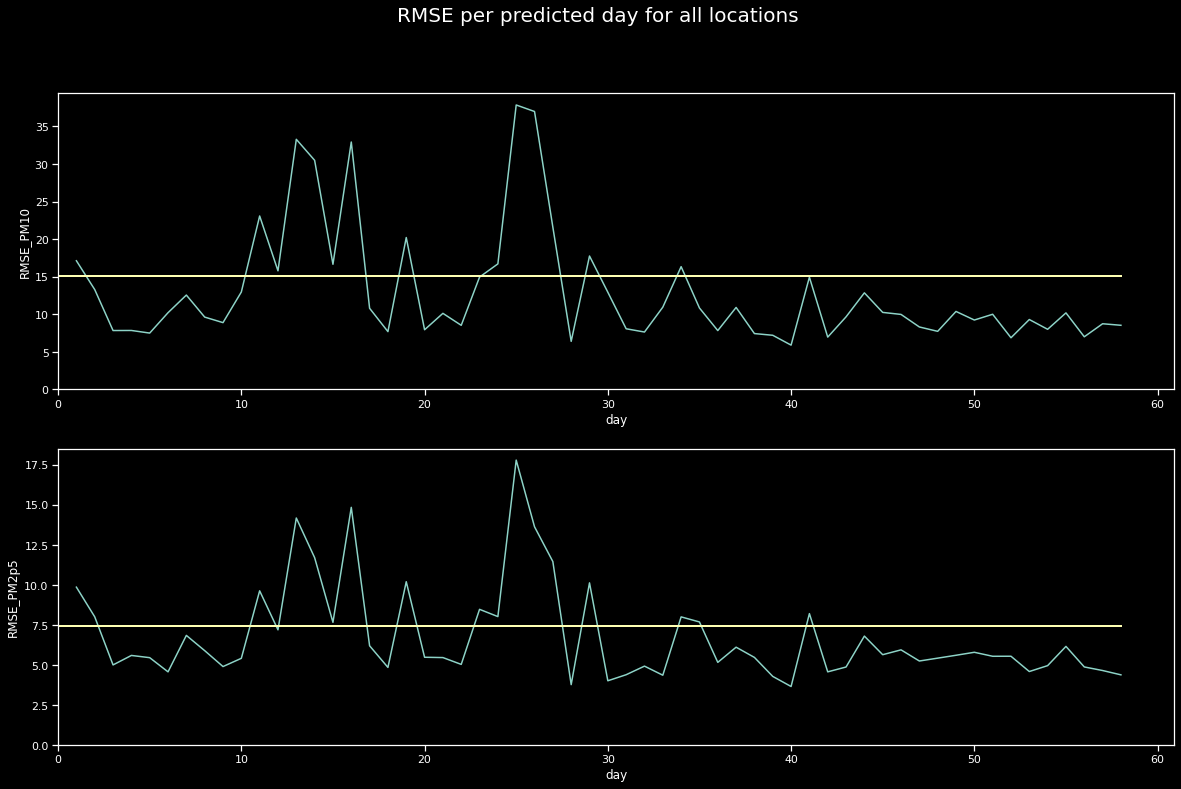

In [68]:
# calculate RMSE for each predicted day, for all data points, Bremen and Frankfurt, respectively and print RMSE for all days and locations (data points)
rmse_all["PM10_pred"], rmse_Bremen["PM10_pred"], rmse_Frankfurt["PM10_pred"] = calc_rmse_base('PM10',  df_base_test)
rmse_all["PM2p5_pred"], rmse_Bremen["PM2p5_pred"], rmse_Frankfurt["PM2p5_pred"] = calc_rmse_base('PM2p5',  df_base_test)

# plot
plt.figure(figsize=(20, 12))
plt.suptitle('RMSE per predicted day for all locations', fontsize=20)
#sns.set_context('notebook')
plt.subplot(2,1,1)
sns.lineplot(data=df_RMSE_base, x='day', y="RMSE_PM10_pred")
plt.plot([0, days], [rmse_all['PM10_pred'], rmse_all['PM10_pred']], linewidth=2)
plt.ylim(0)
plt.xlim(0)
plt.ylabel('RMSE_PM10')

plt.subplot(2,1,2)
sns.lineplot(data=df_RMSE_base, x='day', y="RMSE_PM2p5_pred")
plt.plot([0, days], [rmse_all['PM2p5_pred'], rmse_all['PM2p5_pred']], linewidth=2)
plt.ylim(0)
plt.xlim(0)
plt.ylabel('RMSE_PM2p5');

> There's no obvious increase / decrease of RMSE with predicted day. For a strong seasonality an increase would have been expected.

In [70]:
# calculate RMSE per data point
# PM10
df_base_test['RMSE_PM10'] = np.sqrt((df_base_test['PM10'] - df_base_test['PM10_pred'])**2)

# PM2.5
df_base_test['RMSE_PM2p5'] = np.sqrt((df_base_test['PM2p5'] - df_base_test['PM2p5_pred'])**2)

# show for location 125 at 1 pm
df_base_test.query("location_id==125").loc[4050::24].head(10)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test,PM10_pred,PM2p5_pred,date,day,RMSE_PM10,RMSE_PM2p5
4072,125,2021-12-31 13:00:00,Bremen,53.014,8.886,8.885238,2.003234,4.012381,0.828589,False,NaN,NaN,2021-12-31,0,NaN,NaN
5656,125,2022-01-01 13:00:00,Bremen,53.014,8.886,23.852174,3.866629,9.230000,1.568859,True,18.368970,7.976362,2022-01-01,1,5.483204,1.253638
7240,125,2022-01-02 13:00:00,Bremen,53.014,8.886,8.598889,2.368506,3.605000,0.514921,True,14.094261,6.615944,2022-01-02,2,5.495372,3.010944
8824,125,2022-01-03 13:00:00,Bremen,53.014,8.886,21.633571,4.181948,4.059286,0.828673,True,14.650993,6.635490,2022-01-03,3,6.982578,2.576204
10408,125,2022-01-04 13:00:00,Bremen,53.014,8.886,13.080952,7.530958,5.208571,2.770609,True,15.085079,6.852453,2022-01-04,4,2.004126,1.643882
11992,125,2022-01-05 13:00:00,Bremen,53.014,8.886,18.323684,5.250607,3.103158,0.753518,True,14.775247,6.740714,2022-01-05,5,3.548437,3.637556
13576,125,2022-01-06 13:00:00,Bremen,53.014,8.886,20.878636,5.497976,4.914091,1.529864,True,14.857815,6.760423,2022-01-06,6,6.020821,1.846332
15160,125,2022-01-07 13:00:00,Bremen,53.014,8.886,26.365789,2.620607,14.620526,0.740941,True,14.868170,6.769192,2022-01-07,7,11.497620,7.851335
16744,125,2022-01-08 13:00:00,Bremen,53.014,8.886,28.879091,5.358704,14.271818,2.156577,True,14.849231,6.761522,2022-01-08,8,14.029860,7.510296
18328,125,2022-01-09 13:00:00,Bremen,53.014,8.886,15.467500,3.675952,3.187083,0.809377,True,14.856975,6.763895,2022-01-09,9,0.610525,3.576812


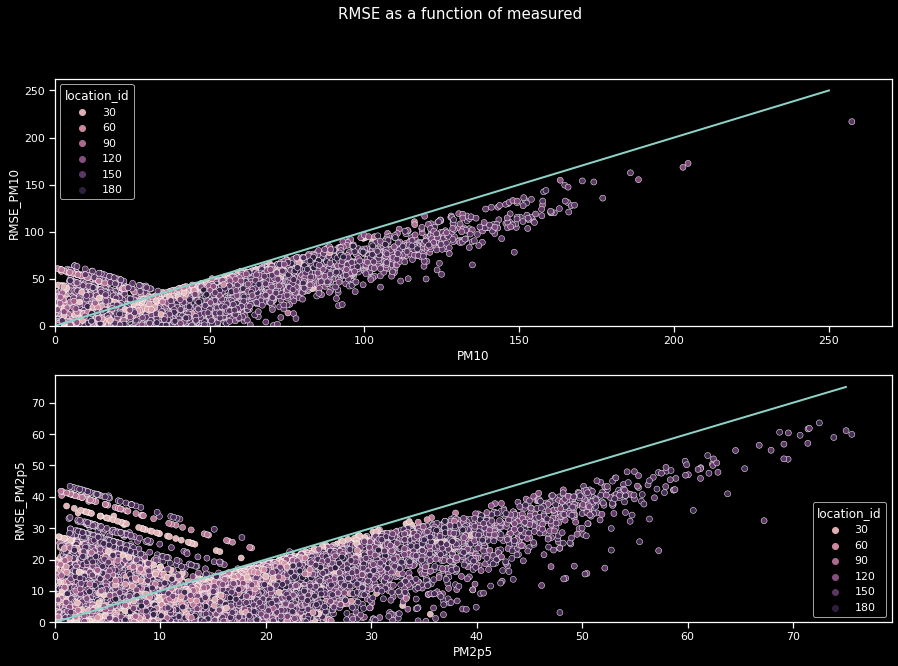

In [74]:
# plot RMSE vs.  PM
plt.figure(figsize=(15, 10))
plt.suptitle(f'RMSE as a function of measured', fontsize=15)

# PM10
plt.subplot(2,1,1)
sns.scatterplot(data=df_base_test, x='PM10', y="RMSE_PM10", hue='location_id')
plt.plot([0, 250], [0, 250], linewidth=2)
plt.ylim(0)
plt.xlim(0)
plt.ylabel('RMSE_PM10')

# PM2.5
plt.subplot(2,1,2)
sns.scatterplot(data=df_base_test, x='PM2p5', y="RMSE_PM2p5", hue='location_id')
plt.plot([0, 75], [0, 75], linewidth=2)
plt.ylim(0)
plt.xlim(0)
plt.ylabel('RMSE_PM2p5');

> Some locations show a wide range of PM values that result in large RMSE for both small and high PM values. This is reasonable for a model that doesn't predict seasonality.

mean RMSE_PM10 for location 125 = 28.74 µg/m3
mean RMSE_PM2p5 for location 125 = 12.4 µg/m3


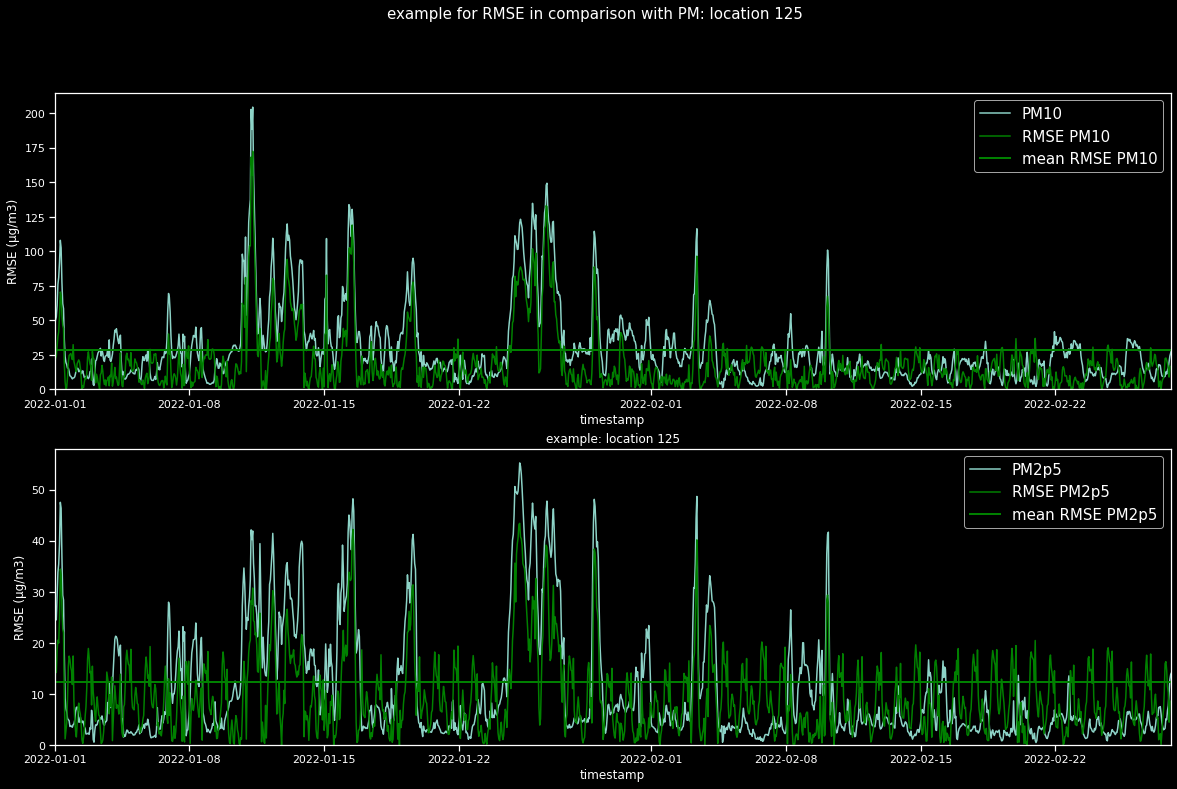

In [73]:
# plot comparison of RMSE and PM for exemplarily location
location = 125

plt.figure(figsize=(20, 12))
plt.suptitle(f'example for RMSE in comparison with PM: location {location}', fontsize=15)

# PM10
# calculate and print mean RMSE
df = df_base_test[df_base_test['location_id']==125][['location_id', 'PM10', 'PM10_pred']].dropna(axis=0) # NaNs have to be dropped for MSE calculation
mean_PM10 = MSE(df['PM10'], df['PM10_pred'], squared=False)
print(f'mean RMSE_PM10 for location {location} = {round(mean_PM10,2)} µg/m3')
# plot
plt.subplot(2,1,1)
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="PM10")
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="RMSE_PM10", color='green')
plt.plot([pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-28')], [mean_PM10, mean_PM10], linewidth=2, color='green')
#sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="PM10_pred")
plt.ylim(0)
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-28'))
plt.ylabel('RMSE (µg/m3)')
plt.legend(['PM10', 'RMSE PM10', 'mean RMSE PM10'], fontsize=15)

# PM 2.5
# calculate and print mean RMSE
df = df_base_test[df_base_test['location_id']==125][['location_id', 'PM2p5', 'PM2p5_pred']].dropna(axis=0) # NaNs have to be dropped for MSE calculation
mean_PM2p5 = MSE(df['PM2p5'], df['PM2p5_pred'], squared=False)
print(f'mean RMSE_PM2p5 for location {location} = {round(mean_PM2p5,2)} µg/m3')
# plot
plt.subplot(2,1,2)
plt.title(f'example: location {location}')
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="PM2p5")
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="RMSE_PM2p5", color='green')
plt.plot([pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-28')], [mean_PM2p5, mean_PM2p5], linewidth=2, color='green')
#sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y="PM2p5_pred")
plt.ylim(0)
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-28'))
plt.ylabel('RMSE (µg/m3)')
plt.legend(['PM2p5', 'RMSE PM2p5', 'mean RMSE PM2p5'], fontsize=15)